# `British Airways Customer Reviews Sentimental Analysis`

In this task, we will be doing some sentimental analysis using python on British Airways(BA) customer reviews extracted from value [Skytrax](https://www.airlinequality.com/) using Roberta Pretrained Model from [HuggingFace](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment).

### `Step 1: Import libraries and NLTK Basics`

In [1]:
import nltk
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
# from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm # progress bar
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud


#### `Step 2: Generic view of the srapped data`

In [2]:
# Having a generic view fo the data befroe cleaning.
df_raw = pd.read_csv("ba_reviews.csv")
print(df_raw.describe().astype(int))
print(df_raw.shape)

df_raw.head()

       cabin staff service  food and beverages  value for money
count                 3686                3408             3407
mean                     3                   2                2
std                      1                   1                1
min                      1                   1                1
25%                      2                   1                1
50%                      3                   3                3
75%                      5                   4                4
max                      5                   5                5
(3822, 14)


,date,name,country,verification,review summary,body,aircraft,traveller type,seat type,route,cabin staff service,food and beverages,value for money,recommend
0,9/07/2024,Daniel Chinellato,Germany,Not Verified,"""left me extremely disappointed""","On March 1st, I flew from Berlin to São Paulo ...",NaN,Business,Economy Class,Berlin to São Paulo via London,4.0,3.0,2.0,no
1,5/07/2024,Flora Dogneton,United Kingdom,Not Verified,“customer service was awful”,The WORST customer experience! British Airways...,NaN,Couple Leisure,Economy Class,London to Corfu,1.0,NaN,NaN,no
2,1/07/2024,Alex Martyn,Canada,Not Verified,"""over 2 weeks to respond""",Had to cancel my flight months in advance due ...,NaN,Solo Leisure,Economy Class,Toronto to London,NaN,NaN,NaN,no
3,30/06/2024,P Jackson,United Kingdom,Trip Verified,“wholly inadequate customer service”,Flight cancelled with no reason given less tha...,NaN,Couple Leisure,Economy Class,London Gatwick to Verona,1.0,1.0,1.0,no
4,26/06/2024,R Thornton,United Kingdom,Trip Verified,“the cabin crew were great”,This is a route I fly regularly. Used first cl...,A320,Business,Business Class,London Heathrow to Paris CDG,5.0,3.0,3.0,yes


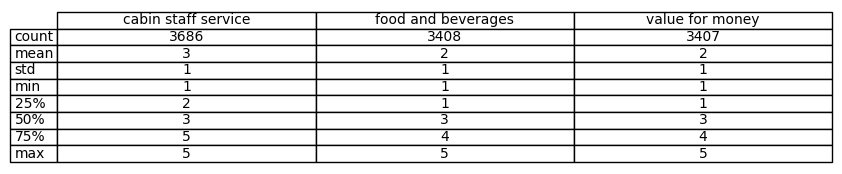

In [3]:
summary = df_raw.describe().astype(int)

# Plot the summary statistics
fig, ax = plt.subplots(figsize=(10, 2))  # Set the size of the figure
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=summary.values, colLabels=summary.columns, rowLabels=summary.index, cellLoc='center', loc='center')

# Save the table as an image
plt.savefig('img/df_describe_output.png', bbox_inches='tight', pad_inches=0.1)
# plt.show()

#### `Step 3: Import and wrangle data`

In [4]:
# wrangle function
def wrangle(data_path): 
    # Read in csv data file using pandas
    df = pd.read_csv(data_path)
    
    # Drop customer names 
    df = df.drop(columns=["name"])
    
    # Select only verified customers
    df = df[(df["verification"] == "Trip Verified")|(df["verification"] == "Verified Review")]
    
    # Replace NaN with 0 in specific columns 
    cols_to_fill = ['cabin staff service', 'food and beverages', 'value for money']  # Columns to replace NaN with 0
    df[cols_to_fill] = df[cols_to_fill].fillna(0)
    
    # Changing data types
    df["cabin staff service"] = df["cabin staff service"].astype(int)
    df["food and beverages"] = df["food and beverages"].astype(int)
    df["value for money"] = df["value for money"].astype(int)
    
    df['review summary'] = df['review summary'].str.strip('“”""')
    
    # Reset index
    df = df.reset_index(drop=True)
    
    
    
    return df

In [5]:
df = wrangle("ba_reviews.csv")
print(df.describe().astype(int))
print(df.shape)

df.head()


       cabin staff service  food and beverages  value for money
count                 2013                2013             2013
mean                     2                   2                2
std                      1                   1                1
min                      0                   0                0
25%                      1                   1                1
50%                      3                   2                2
75%                      4                   3                4
max                      5                   5                5
(2013, 13)


,date,country,verification,review summary,body,aircraft,traveller type,seat type,route,cabin staff service,food and beverages,value for money,recommend
0,30/06/2024,United Kingdom,Trip Verified,wholly inadequate customer service,Flight cancelled with no reason given less tha...,NaN,Couple Leisure,Economy Class,London Gatwick to Verona,1,1,1,no
1,26/06/2024,United Kingdom,Trip Verified,the cabin crew were great,This is a route I fly regularly. Used first cl...,A320,Business,Business Class,London Heathrow to Paris CDG,5,3,3,yes
2,23/06/2024,Canada,Trip Verified,cannot recommend BA,While BA may have made some positive improveme...,A350-1000,Solo Leisure,Economy Class,London Heathrow to Vancouver,2,1,1,no
3,23/06/2024,Canada,Trip Verified,a very poor last impression of BA,British Airways new Club Suite is a marked imp...,A350-1000,Solo Leisure,Business Class,Vancouver to London Heathrow,3,3,2,no
4,18/06/2024,United Kingdom,Trip Verified,happy to recommend BA,"Four very pleasant, on time flights with frien...",A320/A380,Couple Leisure,Business Class,Belfast to San Francisco via London,5,3,4,yes


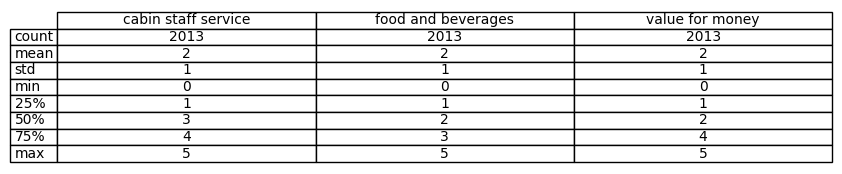

In [6]:
summary = df.describe().astype(int)

# Plot the summary statistics
fig, ax = plt.subplots(figsize=(10, 2))  # Set the size of the figure
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=summary.values, colLabels=summary.columns, rowLabels=summary.index, cellLoc='center', loc='center')

# Save the table as an image
plt.savefig('img/df_describe_verified_output.png', bbox_inches='tight', pad_inches=0.1)
# plt.show()

#### `Step 4: Exploratory Data Analysis`

Bar and Pie Charts to show numerical summary of reviews

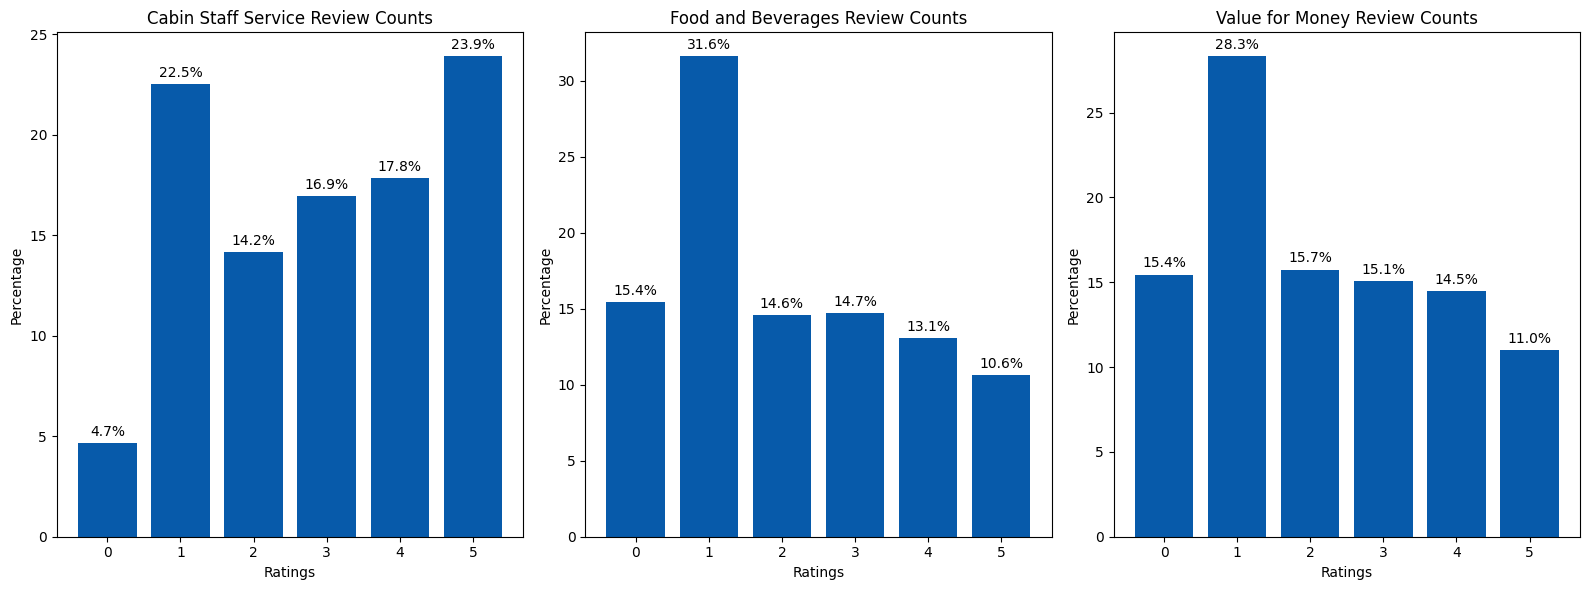

In [7]:
# Value counts for numerical columns
cabin_staff_service_count = df["cabin staff service"].value_counts().sort_index()
food_count = df["food and beverages"].value_counts().sort_index()
value_for_money_count = df["value for money"].value_counts().sort_index()

# Calculate percentages
cabin_staff_service_percentage = (cabin_staff_service_count / cabin_staff_service_count.sum()) * 100
food_percentage = (food_count / food_count.sum()) * 100
value_for_money_percentage = (value_for_money_count / value_for_money_count.sum()) * 100

# Create a figure with 1 row, 3 columns
fig, axs = plt.subplots(1, 3, figsize=(16, 6))

# Define colors
color = '#075AAA'

# Cabin staff service review counts
bars1 = axs[0].bar(cabin_staff_service_percentage.index, cabin_staff_service_percentage.values, color=color)
axs[0].set_title('Cabin Staff Service Review Counts')
axs[0].set_xlabel('Ratings')
axs[0].set_ylabel('Percentage')
axs[0].set_xticks(cabin_staff_service_percentage.index)

# Annotate with percentages
axs[0].bar_label(bars1, labels=[f'{v:.1f}%' for v in cabin_staff_service_percentage.values], padding=3)

# Food and beverages review count
bars2 = axs[1].bar(food_percentage.index, food_percentage.values, color=color)
axs[1].set_title('Food and Beverages Review Counts')
axs[1].set_xlabel('Ratings')
axs[1].set_ylabel('Percentage')
axs[1].set_xticks(food_percentage.index)

# Annotate with percentages
axs[1].bar_label(bars2, labels=[f'{v:.1f}%' for v in food_percentage.values], padding=3)

# Value for money review count
bars3 = axs[2].bar(value_for_money_percentage.index, value_for_money_percentage.values, color=color)
axs[2].set_title('Value for Money Review Counts')
axs[2].set_xlabel('Ratings')
axs[2].set_ylabel('Percentage')
axs[2].set_xticks(value_for_money_percentage.index)

# Annotate with percentages
axs[2].bar_label(bars3, labels=[f'{v:.1f}%' for v in value_for_money_percentage.values], padding=3)

plt.tight_layout()
plt.savefig('img/point_review_BC.png')
plt.show()

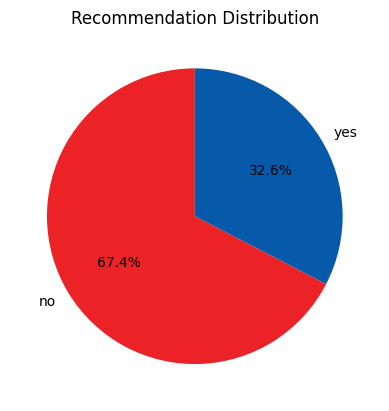

In [8]:
# Count the occurrences of 'yes' and 'no' from the recommend column
recommend_counts = df['recommend'].value_counts()

colors=['#EB2226','#075AAA']

# plot the pie chart
fig, ax =plt.subplots()
ax.pie(
    recommend_counts,
    labels=recommend_counts.index, 
    autopct='%1.1f%%', 
    colors=colors, 
    startangle=90                                                              
)

# set title
ax.set_title('Recommendation Distribution')

# save
plt.savefig('img/recommendation_review_BC.png')

# Display the plot
plt.show()

##### `Grouping the "no recommendations" by country`

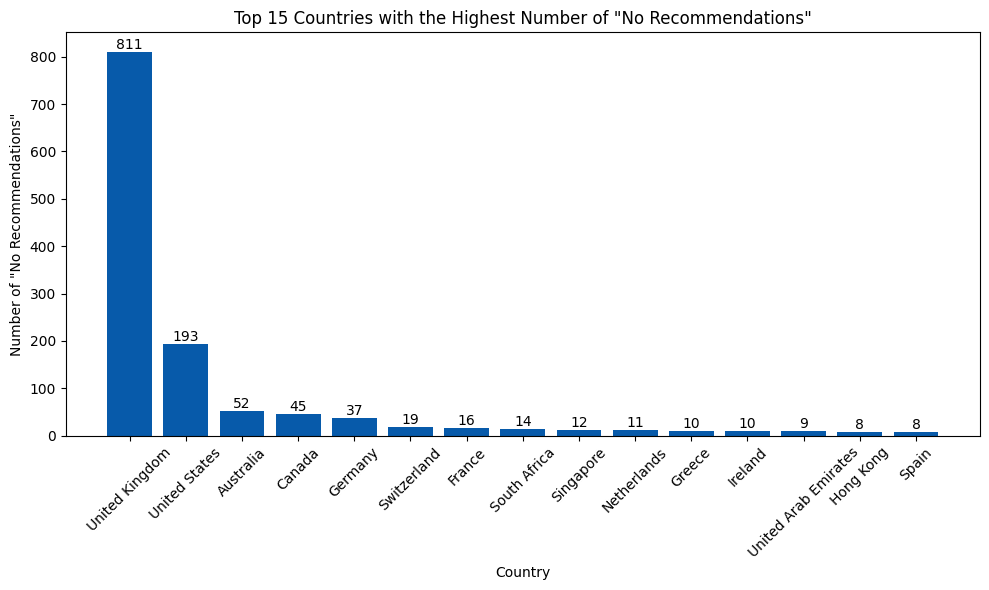

In [9]:
# filtering rows where recommend is 'no' e.i, where customers do not recommend flying BA
no_recommend_df = df[df["recommend"] == "no"]

# Group by country and count the occurances
no_recommend_df_groupby_country = no_recommend_df.groupby('country').size().reset_index(name='count')

top_countries = no_recommend_df_groupby_country.nlargest(15, 'count')

# creaing a bar chart to display the top 15 countries with no recommendation

# Define colors
color = '#075AAA'

plt.figure(figsize=(10, 6))
bar_plot = plt.bar(top_countries['country'], top_countries['count'], color=color  )


# making the numbers appear
for each_bar in bar_plot:
    height = each_bar.get_height()
    plt.text(each_bar.get_x() + each_bar.get_width() / 2, height - 0.1, str(height), ha='center', va='bottom')

plt.xlabel('Country')
plt.ylabel('Number of "No Recommendations"')
plt.title('Top 15 Countries with the Highest Number of "No Recommendations"')
plt.xticks(rotation=45)
plt.tight_layout()

# save
plt.savefig('img/top_15_countries_with_no_in_recommendation.png')
plt.show()




##### `Grouping the "no recommendations" by aircarft`

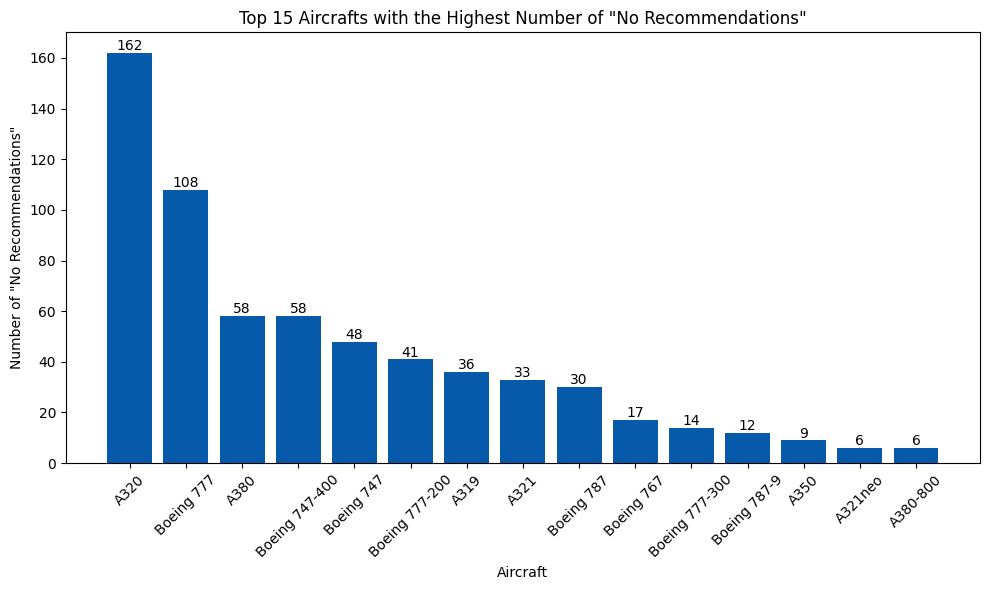

In [10]:
# Group by aircarft and count the occurances
no_recommend_df_groupby_aircraft = no_recommend_df.groupby('aircraft').size().reset_index(name='count')

top_aircrafts = no_recommend_df_groupby_aircraft.nlargest(15, 'count')

# creaing a bar chart to display the top 15 countries with no recommendation

# Define colors
color = '#075AAA'

plt.figure(figsize=(10, 6))
bar_plot = plt.bar(top_aircrafts['aircraft'], top_aircrafts['count'], color=color  )


# making the numbers appear
for each_bar in bar_plot:
    height = each_bar.get_height()
    plt.text(each_bar.get_x() + each_bar.get_width() / 2, height - 0.1, str(height), ha='center', va='bottom')

plt.xlabel('Aircraft')
plt.ylabel('Number of "No Recommendations"')
plt.title('Top 15 Aircrafts with the Highest Number of "No Recommendations"')
plt.xticks(rotation=45)
plt.tight_layout()


plt.savefig('img/top_15_aircrafts_with_no_in_recommendation.png')
plt.show()



### `Step 4: Analysis - Roberta Pretrained Model`

- Use a model trained of a large corpus of data
- Transformer model accounts for the words but also the context related to other words.

In [11]:
# Initialize and tokenize model
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [12]:
#Define a function for the model results
def polarity_scores_roberta(text: str, max_length: int = 512):
    """
    Calculate the sentiment scores of a given text using RoBERTa.

    Parameters:
    text (str): The input text for which the sentiment score is to be calculated.

    Returns:
    dict: A dictionary containing the sentiment scores with keys 'roberta_neg', 'roberta_neu', and 'roberta_pos'.
    """
    try:
        # Tokenize the input text, truncating to max_length
        encoded_text = tokenizer(text, return_tensors='pt', truncation=True, max_length=max_length)
        
        # Tokenize the input text
        encoded_text = tokenizer(text, return_tensors='pt')
        
        # Perform inference with the model without computing gradient as used in training
        with torch.no_grad():
            output = model(**encoded_text)
            
        
        
        # Extract the scores
        scores = output[0][0].detach().numpy()
        
        # Apply softmax to get probabilities
        scores = softmax(scores)
        
        # Round the scores to 3 decimal places
        scores = np.round(scores, 3)
        
        # Map the scores to a dictionary
        scores_dict = {
            'roberta_neg': scores[0],
            'roberta_neu': scores[1],
            'roberta_pos': scores[2]
        }

        return scores_dict

    except IndexError as e:
        print(f"Error processing text: {e}")
        return {'roberta_neg': 0, 'roberta_neu': 0, 'roberta_pos': 0}


In [13]:
# Runing the polarity score on the entire data set

res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        body = row["body"]    
            
        roberta_result = polarity_scores_roberta(body)
        
        res[i] = roberta_result
    except RuntimeError:
        print(f"Broken at id{i}")

  0%|          | 0/2013 [00:00<?, ?it/s]

Broken at id23
Broken at id30
Broken at id36
Broken at id61
Broken at id78
Broken at id139
Broken at id157
Broken at id190
Broken at id240
Broken at id242
Broken at id258
Broken at id276
Broken at id283
Broken at id343
Broken at id350
Broken at id437
Broken at id496
Broken at id553
Broken at id554
Broken at id657
Broken at id676
Broken at id702
Broken at id794
Broken at id818
Broken at id879
Broken at id890
Broken at id971
Broken at id976
Broken at id981
Broken at id992
Broken at id1053
Broken at id1059
Broken at id1060
Broken at id1114
Broken at id1188
Broken at id1217
Broken at id1237
Broken at id1240
Broken at id1241
Broken at id1254
Broken at id1257
Broken at id1272
Broken at id1292
Broken at id1305
Broken at id1339
Broken at id1360
Broken at id1361
Broken at id1381
Broken at id1390
Broken at id1407
Broken at id1449
Broken at id1485
Broken at id1486
Broken at id1551
Broken at id1592
Broken at id1608
Broken at id1613
Broken at id1640
Broken at id1654
Broken at id1658
Broken at id167

In [14]:
# Runing the polarity score on the entire data set

review_res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        review_body = row["review summary"]    
            
        roberta_result = polarity_scores_roberta(review_body)
        
        review_res[i] = roberta_result
    except RuntimeError:
        print(f"Broken at id{i}")

  0%|          | 0/2013 [00:00<?, ?it/s]

In [15]:
# Convert the results to a DataFrame
rev_sum_df = pd.DataFrame(review_res).T
rev_sum_df  = rev_sum_df .merge(df, left_index=True, right_index=True)
print(rev_sum_df.shape)
rev_sum_df.head()

(2013, 16)


,roberta_neg,roberta_neu,roberta_pos,date,country,verification,review summary,body,aircraft,traveller type,seat type,route,cabin staff service,food and beverages,value for money,recommend
0,0.952,0.044,0.003,30/06/2024,United Kingdom,Trip Verified,wholly inadequate customer service,Flight cancelled with no reason given less tha...,NaN,Couple Leisure,Economy Class,London Gatwick to Verona,1,1,1,no
1,0.003,0.015,0.982,26/06/2024,United Kingdom,Trip Verified,the cabin crew were great,This is a route I fly regularly. Used first cl...,A320,Business,Business Class,London Heathrow to Paris CDG,5,3,3,yes
2,0.878,0.112,0.010,23/06/2024,Canada,Trip Verified,cannot recommend BA,While BA may have made some positive improveme...,A350-1000,Solo Leisure,Economy Class,London Heathrow to Vancouver,2,1,1,no
3,0.903,0.091,0.006,23/06/2024,Canada,Trip Verified,a very poor last impression of BA,British Airways new Club Suite is a marked imp...,A350-1000,Solo Leisure,Business Class,Vancouver to London Heathrow,3,3,2,no
4,0.003,0.123,0.874,18/06/2024,United Kingdom,Trip Verified,happy to recommend BA,"Four very pleasant, on time flights with frien...",A320/A380,Couple Leisure,Business Class,Belfast to San Francisco via London,5,3,4,yes


### Why the broken reviews?
When using RoBERTa model, the maximum sequence of lenght that the model can handle is around 512 tokens. To avoid such, you can truncate some of the reviews by chunking them to 512 tokens using the following function.

In [16]:
# # Handling long text by chunking
# def chunk_text(text: str, max_length: int = 512, stride: int = 128):
#     """
#     Split the text into chunks with a specified maximum length and stride.

#     Parameters:
#     text (str): The input text to be split.
#     max_length (int): The maximum length of each chunk.
#     stride (int): The stride for splitting the text.

#     Returns:
#     list: A list of text chunks.
#     """
#     encoded_text = tokenizer.encode(text, truncation=False)
#     chunks = []
#     for i in range(0, len(encoded_text), max_length - stride):
#         chunk = encoded_text[i:i + max_length]
#         chunks.append(tokenizer.decode(chunk, skip_special_tokens=True))
#     return chunks

# # Running the polarity score on the entire data set with chunking
# res = {}
# for i, row in tqdm(df.iterrows(), total=len(df)):
#     try:
#         body = row["body"]
        
#         # Process the text in chunks if it is too long
#         chunks = chunk_text(body)
#         chunk_scores = {'roberta_neg': 0, 'roberta_neu': 0, 'roberta_pos': 0}
        
#         for chunk in chunks:
#             chunk_result = polarity_scores_roberta(chunk)
#             for key in chunk_scores:
#                 chunk_scores[key] += chunk_result[key]
        
#         # Average the scores across chunks
#         chunk_scores = {k: v / len(chunks) for k, v in chunk_scores.items()}
        
#         res[i] = chunk_scores
#     except RuntimeError as e:
#         print(f"Broken at id {i}: {e}")



In [17]:
# Convert the results to a DataFrame
result_df = pd.DataFrame(res).T
result_df  = result_df .merge(df, left_index=True, right_index=True)
print(result_df .shape)
result_df.head()

(1931, 16)


,roberta_neg,roberta_neu,roberta_pos,date,country,verification,review summary,body,aircraft,traveller type,seat type,route,cabin staff service,food and beverages,value for money,recommend
0,0.980,0.018,0.002,30/06/2024,United Kingdom,Trip Verified,wholly inadequate customer service,Flight cancelled with no reason given less tha...,NaN,Couple Leisure,Economy Class,London Gatwick to Verona,1,1,1,no
1,0.026,0.102,0.871,26/06/2024,United Kingdom,Trip Verified,the cabin crew were great,This is a route I fly regularly. Used first cl...,A320,Business,Business Class,London Heathrow to Paris CDG,5,3,3,yes
2,0.680,0.253,0.067,23/06/2024,Canada,Trip Verified,cannot recommend BA,While BA may have made some positive improveme...,A350-1000,Solo Leisure,Economy Class,London Heathrow to Vancouver,2,1,1,no
3,0.370,0.377,0.253,23/06/2024,Canada,Trip Verified,a very poor last impression of BA,British Airways new Club Suite is a marked imp...,A350-1000,Solo Leisure,Business Class,Vancouver to London Heathrow,3,3,2,no
4,0.140,0.288,0.572,18/06/2024,United Kingdom,Trip Verified,happy to recommend BA,"Four very pleasant, on time flights with frien...",A320/A380,Couple Leisure,Business Class,Belfast to San Francisco via London,5,3,4,yes


sentiment
negative    62.713620
positive    28.638011
neutral      8.648369
Name: count, dtype: float64


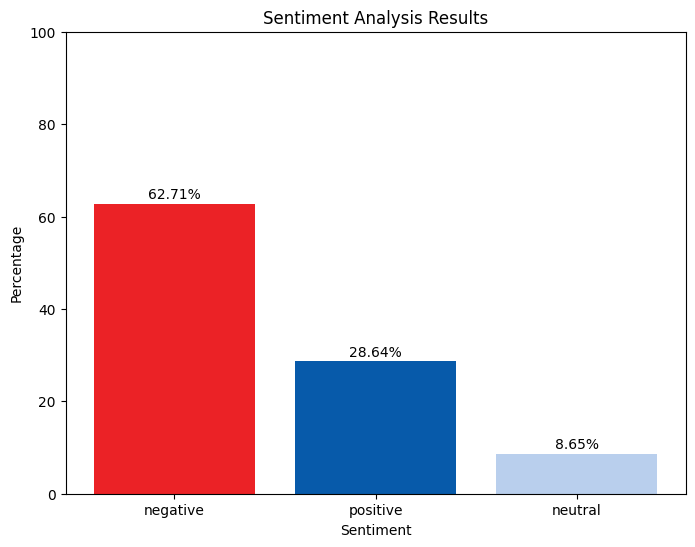

In [26]:

# Determine the sentiment for each row
result_df['sentiment'] = result_df[['roberta_neg', 'roberta_neu', 'roberta_pos']].idxmax(axis=1)

# Replace the column names with actual sentiment names
result_df['sentiment'] = result_df['sentiment'].map({
    'roberta_neg': 'negative',
    'roberta_neu': 'neutral',
    'roberta_pos': 'positive'
})

# Count the number of each sentiment
sentiment_counts = result_df['sentiment'].value_counts()


# Calculate the percentages
sentiment_percentages = (sentiment_counts / sentiment_counts.sum()) * 100

print(sentiment_percentages)
colors=['#EB2226','#075AAA', '#b9cfed' ]


# Plot the bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(sentiment_percentages.index, sentiment_percentages, color=colors)

# Add percentages on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval:.2f}%', ha='center', va='bottom')

plt.xlabel('Sentiment')
plt.ylabel('Percentage')
plt.title('Sentiment Analysis Results')
plt.ylim(0, 100)
plt.savefig('img/sentiment_analysis_result.png')
plt.show()

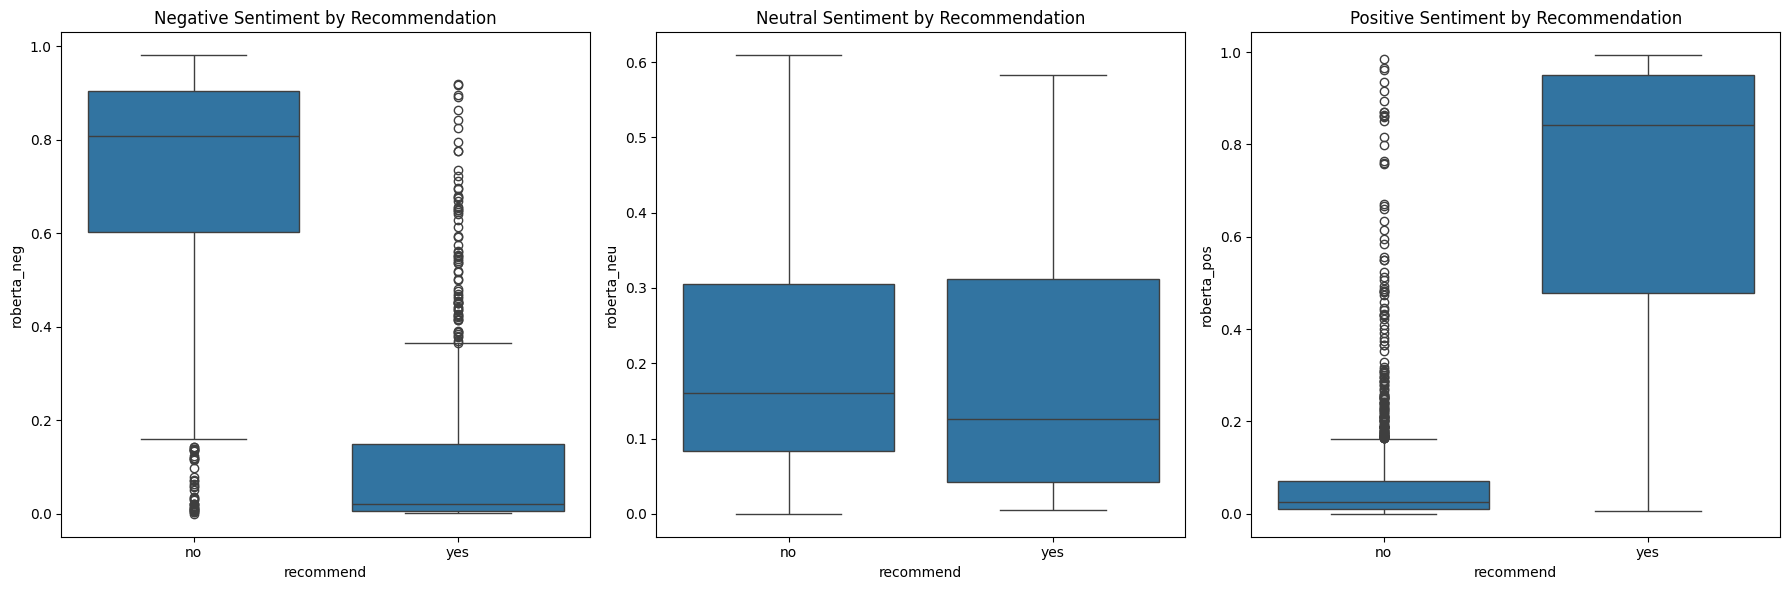

In [18]:
# Box plot to compare sentiment scores by recommendation
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

sns.boxplot(x='recommend', y='roberta_neg', data=result_df, ax=axs[0])
axs[0].set_title('Negative Sentiment by Recommendation')
sns.boxplot(x='recommend', y='roberta_neu', data=result_df, ax=axs[1])
axs[1].set_title('Neutral Sentiment by Recommendation')
sns.boxplot(x='recommend', y='roberta_pos', data=result_df, ax=axs[2])
axs[2].set_title('Positive Sentiment by Recommendation')

plt.tight_layout()
plt.show()


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


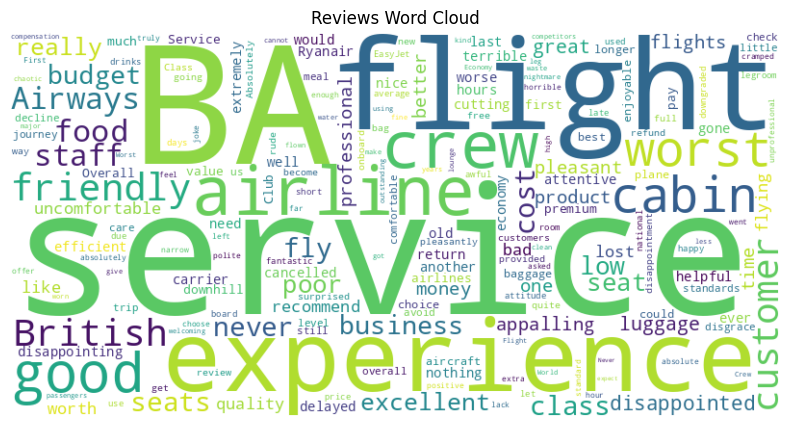

In [19]:
# downloading stopwords dataset
nltk.download('stopwords')

# processing the reviews
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words and word.isalpha()]
    
    return ' '.join(filtered_tokens)


word_reviews = df['review summary'].apply(preprocess_text)

all_reviews = ' '.join(word_reviews)

word_counts = Counter(all_reviews.split())

most_common_words = word_counts.most_common(20)

most_common_df = pd.DataFrame(most_common_words, columns=['word', 'frequency'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Reviews Word Cloud')
plt.show()




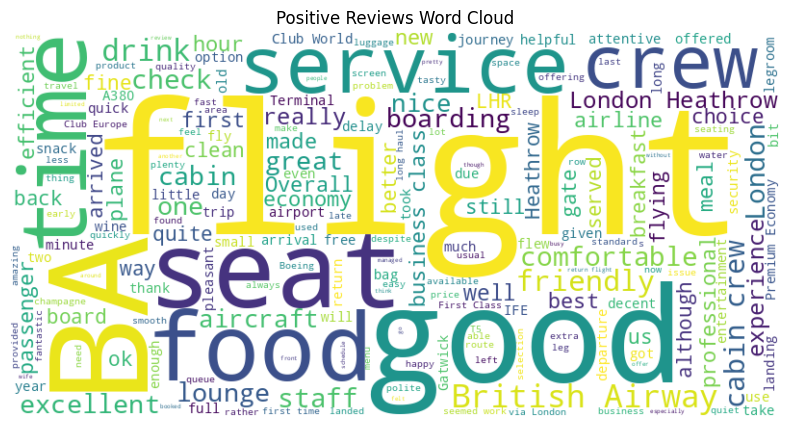

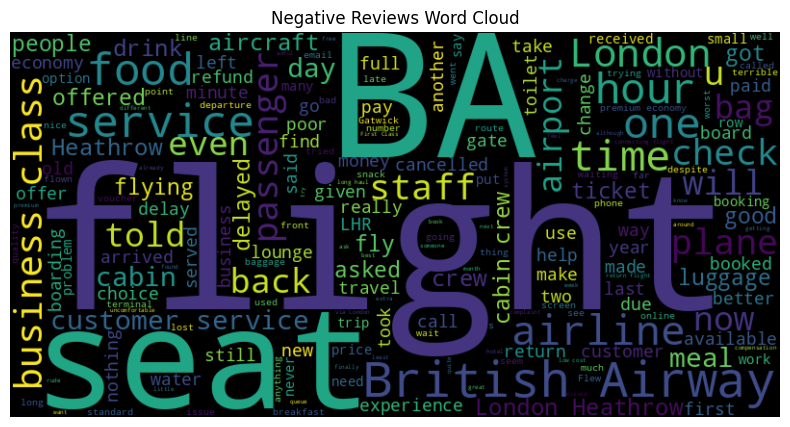

In [27]:
# Word clouds for positive and negative reviews
from wordcloud import WordCloud

positive_reviews = ' '.join(result_df[result_df['roberta_pos'] > 0.5]['body'])
negative_reviews = ' '.join(result_df[result_df['roberta_neg'] > 0.5]['body'])

wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
wordcloud_neg = WordCloud(width=800, height=400, background_color='black').generate(negative_reviews)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Reviews Word Cloud')
plt.savefig('img/pos_wordcloud')
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Reviews Word Cloud')
plt.savefig('img/neg_wordcloud')
plt.show()